In [10]:
%pylab
%matplotlib inline
import numpy as np 
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
def readfile(filename, n,d):
    y = np.zeros(n) # targets
    X = np.zeros((n,d)) # input matrix each row is a sample data point
    li = 0 
    with open(filename, "rb") as f:
        for line in f:
           if li>=n : 
             break;
           parts = line.split()
           y[li] = float(parts[0])
           for i in range(len(parts)): 
                if i >0 and parts[i] != '\n': 
                    fparts = parts[i].split(":")
                    X[li,int(fparts[0])-1] = float(fparts[1])
           li = li +1
    return (y,X)


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [11]:
def grad_ridge(w,X,y,lambd): 
    n, d = X.shape
    g = np.zeros(d)
    for i in range(n):
        dot = np.dot(X[i,:],np.transpose(w))
        g = np.add(g,(2*(dot-y[i])*X[i,:])/float(n))
    g = np.add(g,lambd*w)
    return g,1.0
def risk_ridge(w,X,y,lambd): 
    n, d = X.shape
    delta = (np.dot(X,w)-y)/float(math.sqrt(n))
    return np.dot(np.transpose(delta),delta) + 0.5*lambd*np.dot(np.transpose(w),w)
    
def gradient_desc(X,y,lambd,step_size,grad,risk,itrs,w0 = None): 
    n, d = X.shape
    if w0 is None: 
        w = np.zeros(d)
    else: 
        w = w0
    effective_iters = 0
    stat = [0,risk(w,X,y,lambd)]
    while effective_iters < itrs: 
        g, c = grad(w,X,y,lambd) 
        w = w -step_size*g
        effective_iters = effective_iters+c
        risk_value = risk(w,X,y,lambd)
        n_stat = [effective_iters,risk_value]
        stat = np.c_[stat,n_stat]
        #print("loss[{}]={}".format(effective_iters,risk_value))
    return stat,w
def theortical_bound(X,y,lambd,step_size,risk,itrs,w0 = None): 
    n, d = X.shape
    if w0 is None: 
        w = np.zeros(d)
    else: 
        w = w0
    effective_iters = 0
    init_error = risk(w,X,y,lambd)
    stat = [0,init_error]
    while effective_iters < itrs: 
        effective_iters = effective_iters+1
        error = pow(1-2*step_size*lambd,2*effective_iters)*init_error
        n_stat = [effective_iters,error]
        stat = np.c_[stat,n_stat]
    return stat

In [29]:
def empirical_vs_theoretical(X,y,lambd,step_size, epochs, plotname):
    cov_mat = np.dot(np.transpose(X),X)/float(n)
    w_start = np.dot(np.linalg.inv(np.add(2*cov_mat,lambd*np.eye(d))),2.0*np.dot(np.transpose(X),y)/float(n))
    opt_risk = risk_ridge(w_start,X,y,lambd)
    mu = np.dot(np.transpose(X),y)/float(n)
    def grad_eff(w,X,y,lambd): 
        g = 2*np.dot(cov_mat,w)
        g = (g-2*mu)
        g = g + lambd*w
        return g,1.0
    def risk(w,X,y,lambd):
        return risk_ridge(w,X,y,lambd)-opt_risk
    [stat,w] = gradient_desc(X,y,lambd,step_size,grad_eff,risk,epochs)
    stat2 = theortical_bound(X,y,lambd,step_size,risk,epochs)
    plt.plot((stat[0,:]),np.log10(stat[1,:]),label='empirical')
    plt.plot((stat2[0,:]),np.log10(stat2[1,:]),label='theortical')
    lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
    plt.savefig(plotname, facecolor='w', edgecolor='w',
             orientation='portrait',  format='eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
def initialization(X,y,lambd,step_size, epochs, plotname):
    cov_mat = np.dot(np.transpose(X),X)/float(n)
    w_start = np.dot(np.linalg.inv(np.add(2*cov_mat,lambd*np.eye(d))),2.0*np.dot(np.transpose(X),y)/float(n))
    opt_risk = risk_ridge(w_start,X,y,lambd)
    mu = np.dot(np.transpose(X),y)/float(n)
    diag,U = np.linalg.eig(cov_mat)
    def grad_eff(w,X,y,lambd): 
        g = 2*np.dot(cov_mat,w)
        g = (g-2*mu)
        g = g + lambd*w
        return g,1.0
    def risk(w,X,y,lambd):
        return risk_ridge(w,X,y,lambd)-opt_risk
    [stat,w] = gradient_desc(X,y,lambd,step_size,grad_eff,risk,epochs)
    [stat2,w] = gradient_desc(X,y,lambd,step_size,grad_eff,risk,epochs,w0 = 100*U[:,0])
    [stat3,w] = gradient_desc(X,y,lambd,step_size,grad_eff,risk,epochs,w0 = 100*U[:,d-1])
    plt.plot((stat[0,:]),np.log10(stat[1,:]),label='$w_0 = 0$')
    plt.plot((stat2[0,:]),np.log10(stat2[1,:]),label='$w_0 = 100 u_1$')
    plt.plot((stat3[0,:]),np.log10(stat3[1,:]),label='$w_0 = 100 u_d$')
    lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
    plt.savefig(plotname, facecolor='w', edgecolor='w',
             orientation='portrait',  format='eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
def without_reg(X,y,step_size, epochs, plotname):
    lambd = 0.0
    cov_mat = np.dot(np.transpose(X),X)/float(n)
    diag_v,U = np.linalg.eig(cov_mat)
    diag_v = np.abs(diag_v)
    mu = np.dot(np.transpose(X),y)/float(n)
    inds = diag_v>pow(10,-6)
    w_start = np.dot(np.dot(np.dot(U[:,inds],np.diag(1.0/diag_v[inds])),np.transpose(U[:,inds])),mu)
    opt_risk = risk_ridge(w_start,X,y,0)
    print(opt_risk)
    def grad_eff(w,X,y,lambd): 
        g = 2*np.dot(cov_mat,w)
        g = (g-2*mu)
        g = g + lambd*w
        return g,1.0
    def risk(w,X,y,lambd):
        return risk_ridge(w,X,y,lambd)-opt_risk
    [stat,w] = gradient_desc(X,y,lambd,step_size,grad_eff,risk,epochs)
    plt.plot((stat[0,:]),np.log10(stat[1,:]))
    #lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
    #          fancybox=True, shadow=True, ncol=5)
    plt.savefig(plotname)

(0.354887661516+0j)


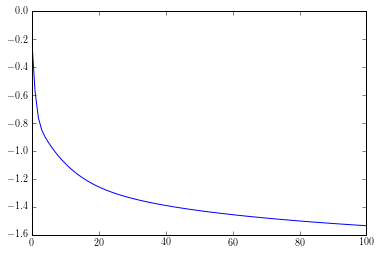

In [32]:
# empirical convergence vs theoretical convergence

n = 49749; 
d = 300; 
filename = "../datasets/w8a"
plotname = "plot/reg_free_w8a.eps"
epochs = 100
y, X = readfile(filename,n,d)
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;

step_size = 0.1
lambd = 10/float(n)
#empirical_vs_theoretical(X,y,lambd,step_size, epochs, plotname)
#initialization(X,y,lambd,step_size, epochs, plotname)
without_reg(X,y,step_size, epochs, plotname)

0.699799284562


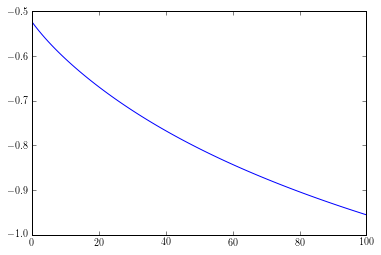

In [31]:
n = 581012; 
d = 54; 
filename = "../datasets/covtype.libsvm.binary.scale"
plotname = "plot/reg_free_covtype.eps"
epochs = 100
y, X = readfile(filename,n,d)
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;

step_size = 0.1
lambd = 10/float(n)
#empirical_vs_theoretical(X,y,lambd,step_size, epochs, plotname)
#initialization(X,y,lambd,step_size, epochs, plotname)
without_reg(X,y,step_size, epochs, plotname)

(0.448429474558+0j)


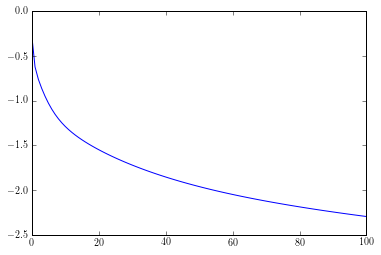

In [30]:
n = 32560; 
d = 123; 
filename = "../datasets/a9a"
plotname = "plot/reg_free_a9a.eps"
epochs = 100.0
y, X = readfile(filename,n,d)
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;

step_size = 0.1
lambd = 10/float(n)
#empirical_vs_theoretical(X,y,lambd,step_size, epochs, plotname)
#initialization(X,y,lambd,step_size, epochs, plotname)
without_reg(X,y,step_size, epochs, plotname)

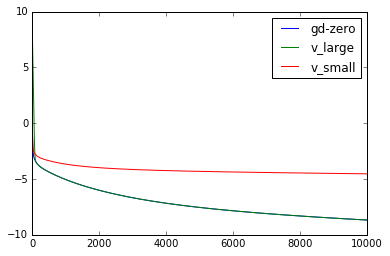

In [47]:
import math
n = 10100; 
d = 54; 
filename = "../datasets/covtype.libsvm.binary.scale"
y, X = readfile(filename,n,d)
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
step_size = 0.01
c = 10.0
lambd_large = c/float(n)
lambd_small = c/float(n)
cov_mat = np.dot(np.transpose(X),X)/float(n)
w_start = np.dot(np.linalg.inv(np.add(2*cov_mat,lambd_small*np.eye(d))),2.0*np.dot(np.transpose(X),y)/float(n))
w_start2 = np.dot(np.linalg.inv(np.add(2*cov_mat,lambd_large*np.eye(d))),2.0*np.dot(np.transpose(X),y)/float(n))
opt_risk = risk_ridge(w_start,X,y,lambd_small)
opt_risk2 = risk_ridge(w_start2,X,y,lambd_large)
diag,U = np.linalg.eig(cov_mat)
def risk_small(w,X,y,lambd):
    return risk_ridge(w,X,y,lambd)-opt_risk
def risk_large(w,X,y,lambd): 
    return risk_ridge(w,X,y,lambd)-opt_risk2
mu = np.dot(np.transpose(X),y)/float(n)
def grad_eff(w,X,y,lambd): 
    g = 2*np.dot(cov_mat,w)
    g = (g-2*mu)
    g = g + lambd*w
    return g,1.0
epochs = 10000
[stat,w] = gradient_desc(X,y,lambd_small,step_size,grad_eff,risk_small,epochs)
[stat2,w2] = gradient_desc(X,y,lambd_small,step_size,grad_eff,risk_small,epochs,10*U[:,0])
[stat3,w3] = gradient_desc(X,y,lambd_small,step_size,grad_eff,risk_small,epochs,10*U[:,d-1])
plt.plot((stat[0,:]),np.log2(stat[1,:]),label='gd-zero')
plt.plot((stat2[0,:]),np.log2(stat2[1,:]),label='v_large')
plt.plot((stat3[0,:]),np.log2(stat3[1,:]),label='v_small')
plt.legend()

In [34]:
np.linalg.norm(mu)

1.17951504741694

In [26]:
n = 581012; 
d = 54; 
filename = "../datasets/covtype.libsvm.binary.scale"
y, X = readfile(filename,n,d)
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
step_size = 0.3
c = 500
lambd_small = 1.0/float(n)
lambd_large = c/float(n)
cov_mat = 2*np.dot(np.transpose(X),X)/float(n)
w_start = np.dot(np.linalg.inv(np.add(cov_mat,lambd_small*np.eye(d))),2.0*np.dot(np.transpose(X),y)/float(n))
w_start2 = np.dot(np.linalg.inv(np.add(cov_mat,lambd_large*np.eye(d))),2.0*np.dot(np.transpose(X),y)/float(n))
opt_risk = risk_ridge(w_start,X,y,lambd_small)
opt_risk2 = risk_ridge(w_start2,X,y,lambd_large)
def risk_small(w,X,y,lambd):
    return risk_ridge(w,X,y,lambd)-opt_risk
def risk_large(w,X,y,lambd): 
    return risk_ridge(w,X,y,lambd)-opt_risk2
[stat,w] = gradient_desc(X,y,lambd_small,0.1,grad_ridge,risk_small,1000)
#[stat2,w2] = gradient_desc(X,y,lambd_large,0.1,grad_ridge,risk_large,1000)
plt.plot((stat[0,500:-1]),np.log2(stat[1,500:-1]),label='lambda-small')
#plt.plot((stat2[0,:]),np.log10(stat2[1,:]),label='lambda-large')
plt.legend()

KeyboardInterrupt: 

In [ ]:
opt_risk2

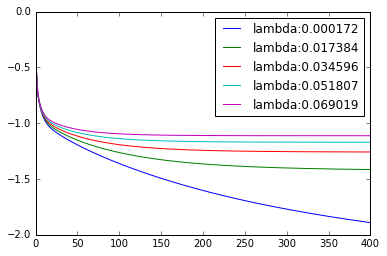

In [19]:
n = 5810; 
d = 54; 
filename = "../datasets/covtype.libsvm.binary.scale"
y, X = readfile(filename,n,d)
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
step_size = 0.1
c = 50.0
lambda_main = 1.0/float(n)
cov_mat = np.dot(np.transpose(X),X)/float(n)
[U,S,V] = np.linalg.svd(cov_mat)
w_star = np.dot(np.linalg.inv(np.add(cov_mat,0.5*lambda_main*np.eye(d))),np.dot(np.transpose(X),y)/float(n))
opt_risk = risk_ridge(w_star,X,y,lambda_main)
mu = np.dot(np.transpose(X),y)/float(n)
def grad_eff(w,X,y,lambd): 
    g = 2*np.dot(cov_mat,w)
    g = (g-2*mu)
    g = g + lambd*w
    return g,1.0
def risk_eval(w,X,y,lambd):
        ind = 35
        delta = np.dot(w_star,U[:,ind].transpose()) 
        return abs(delta)
def risk_eval2(w,X,y,lambd):
        return risk_ridge(w,X,y,lambd) -opt_risk
for j in range(5):
    lambd = (j)*100*lambda_main + lambda_main
    [stat,w] = gradient_desc(X,y,lambd,step_size,grad_eff,risk_eval2,400)
    label_i = 'lambda:%f' % lambd
    plt.plot((stat[0,:]),np.log10(stat[1,:]),label= label_i)
plt.legend()

In [ ]:
n = 3256; 
d = 123; 
y, X = readfile(filename,n,d)
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
step_size = 0.1
c = 50.0
lambd_small = 1.0/float(n)
lambd_large = c/float(n)
cov_mat = 2*np.dot(np.transpose(X),X)/float(n)
w_start = np.dot(np.linalg.inv(np.add(cov_mat,lambd_small*np.eye(d))),2.0*np.dot(np.transpose(X),y)/float(n))
w_start2 = np.dot(np.linalg.inv(np.add(cov_mat,lambd_large*np.eye(d))),2.0*np.dot(np.transpose(X),y)/float(n))
opt_risk = risk_ridge(w_start,X,y,lambd_small)
opt_risk2 = risk_ridge(w_start2,X,y,lambd_large)
def risk_small2(w,X,y,lambd):
    return risk_ridge(w,X,y,lambd_small)-opt_risk
[stat,w] = gradient_desc(X,y,lambd_small,step_size,grad_ridge,risk_small2,200)
[stat2,w2] = gradient_desc(X,y,lambd_large,step_size,grad_ridge,risk_small2,200)
plt.plot((stat[0,:]),np.log10(stat[1,:]),label='lambda-small')
plt.plot((stat2[0,:]),np.log10(stat2[1,:]),label='lambda-large')
plt.legend()

In [ ]:
n = 581012; 
d = 54; 
filename = "../datasets/covtype.libsvm.binary.scale"
y, X = readfile(filename,n,d)
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
tr_size = 400000
te_size = 181012
rperm = np.random.permutation(n)
X = np.c_[X,np.ones(n)]
Xtr = X[rperm[0:tr_size],:]
ytr = y[rperm[0:tr_size]]
Xte = X[rperm[tr_size:tr_size+te_size],:]
yte = y[rperm[tr_size:tr_size+te_size]]
mu = np.dot(np.transpose(Xtr),ytr)/float(n)
cov_mat = np.dot(np.transpose(Xtr)/math.sqrt(n),Xtr/math.sqrt(n))
w, v = np.linalg.eig(cov_mat)
T = 11
test_error = np.zeros(T)
def classfication_error(w,X,y): 
    error = 0 
    n = len(y)
    for i in range(n): 
        out = np.sign(np.dot(w,X[i,:]))
        if out != y[i]: 
            error = error + 1.0/float(n)
    return error
for i in range(T): 
    si = min(5*(i+1),d+1)
    sub_v = v[:,0:si]
    sub_w = w[0:si]
    w_star = np.dot(np.dot(np.dot(sub_v,np.diag(1.0/sub_w)),np.transpose(sub_v)),mu)
    test_error[i] = classfication_error(w_star,Xtr,ytr)
    print(test_error[i])

In [ ]:
def classfication_error(w,X,y): 
        error = 0 
        n = len(y)
        for i in range(n): 
            out = np.sign(np.dot(w,X[i,:]))
            if out != y[i]: 
                error = error + 1.0/float(n)
        return error
n = 581012; 
d = 54; 
filename = "../datasets/covtype.libsvm.binary.scale"
y, X = readfile(filename,n,d)
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
tr_size = 481012
te_size = 100000
rep = 5 
T = 20
test_error = np.zeros(T)
sizes = np.zeros(T)

for j in range(rep): 
    print(j)
    rperm = np.random.permutation(n)
    X = np.c_[X,np.ones(n)]
    Xtr = X[rperm[0:tr_size],:]
    ytr = y[rperm[0:tr_size]]
    Xte = X[rperm[tr_size:tr_size+te_size],:]
    yte = y[rperm[tr_size:tr_size+te_size]]
    mu = np.dot(np.transpose(Xtr),ytr)/float(tr_size)
    cov_mat = np.dot(np.transpose(Xtr)/math.sqrt(tr_size),Xtr/math.sqrt(tr_size))
    w, v = np.linalg.eig(cov_mat)

    for i in range(T): 
        si = min(5*(i+1),d+1)
        sizes[i] = si
        sub_v = v[:,0:si]
        sub_w = w[0:si]
        w_star = np.dot(np.dot(np.dot(sub_v,np.diag(1.0/sub_w)),np.transpose(sub_v)),mu)
        test_error[i] = test_error[i] + classfication_error(w_star,Xte,yte)
test_error = test_error/float(rep)
plt.plot(sizes,test_error)

In [ ]:
def classfication_error(w,X,y): 
        error = 0 
        n = len(y)
        for i in range(n): 
            out = np.sign(np.dot(w,X[i,:]))
            if out != y[i]: 
                error = error + 1.0/float(n)
        return error
n = 32560; 
d = 123; 
filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
tr_size = 22569
te_size = 10000
rep = 5 
T = 20
test_error = np.zeros(T)
sizes = np.zeros(T)

for j in range(rep): 
    print(j)
    rperm = np.random.permutation(n)
    X = np.c_[X,np.ones(n)]
    Xtr = X[rperm[0:tr_size],:]
    ytr = y[rperm[0:tr_size]]
    Xte = X[rperm[tr_size:tr_size+te_size],:]
    yte = y[rperm[tr_size:tr_size+te_size]]
    mu = np.dot(np.transpose(Xtr),ytr)/float(tr_size)
    cov_mat = np.dot(np.transpose(Xtr)/math.sqrt(tr_size),Xtr/math.sqrt(tr_size))
    w, v = np.linalg.eig(cov_mat)

    for i in range(T): 
        si = min(5*(i+1),d+1)
        sizes[i] = si
        sub_v = v[:,0:si]
        sub_w = w[0:si]
        w_star = np.dot(np.dot(np.dot(sub_v,np.diag(1.0/sub_w)),np.transpose(sub_v)),mu)
        test_error[i] = test_error[i] + classfication_error(w_star,Xte,yte)
test_error = test_error/float(rep)
plt.plot(sizes,test_error)

In [ ]:
def classfication_error(w,X,y): 
        error = 0 
        n = len(y)
        for i in range(n): 
            out = np.sign(np.dot(w,X[i,:]))
            if out != y[i]: 
                error = error + 1.0/float(n)
        return error
n = 49749; 
d = 300; 
filename = "../datasets/w8a"
y, X = readfile(filename,n,d)
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
tr_size = 39749
te_size = 1000
rep = 5 
T = 20
test_error = np.zeros(T)
sizes = np.zeros(T)

for j in range(rep): 
    print(j)
    rperm = np.random.permutation(n)
    X = np.c_[X,0.1*np.ones(n)]
    Xtr = X[rperm[0:tr_size],:]
    ytr = y[rperm[0:tr_size]]
    Xte = X[rperm[tr_size:tr_size+te_size],:]
    yte = y[rperm[tr_size:tr_size+te_size]]
    mu = np.dot(np.transpose(Xtr),ytr)/float(tr_size)
    cov_mat = np.dot(np.transpose(Xtr)/math.sqrt(tr_size),Xtr/math.sqrt(tr_size))
    w, v = np.linalg.eig(cov_mat)

    for i in range(T): 
        si = min(5*(i)+1,d+1)
        sizes[i] = si
        sub_v = v[:,0:si]
        sub_w = w[0:si]
        w_star = np.dot(np.dot(np.dot(sub_v,np.diag(1.0/sub_w)),np.transpose(sub_v)),mu)
        test_error[i] = test_error[i] + classfication_error(w_star,Xte,yte)
test_error = test_error/float(rep)
plt.plot(sizes,test_error)

In [ ]:
y[1:1000]

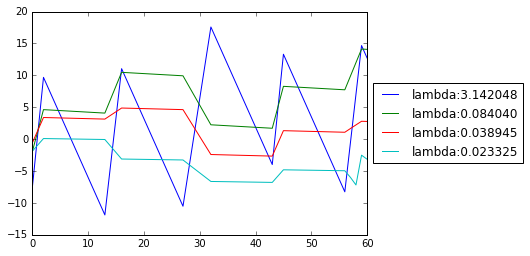

In [14]:
n = 581000; 
d = 54; 
filename = "../datasets/covtype.libsvm.binary.scale"
y, X = readfile(filename,n,d)
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
step_size = 0.1
c = 50.0
lambda_main = 1.0/float(n)
cov_mat = np.dot(np.transpose(X),X)/float(n)
diag, v = np.linalg.eig(cov_mat)
w_star = np.dot(np.linalg.inv(np.add(cov_mat,0.5*lambda_main*np.eye(d))),np.dot(np.transpose(X),y)/float(n))
#opt_risk = risk_ridge(w_start,X,y,lambda_main)
mu = np.dot(np.transpose(X),y)/float(n)
dots = np.dot(v.transpose(),mu)
def grad_eff(w,X,y,lambd): 
    g = 2*np.dot(cov_mat,w)
    g = (g-2*mu)
    g = g + lambd*w
    return g,1.0
def gradient_desc_adapt_steps(X,y,lambd,step_size,grad,risk,itrs,w0 = None): 
    n, d = X.shape
    if w0 is None: 
        w = np.zeros(d)
    else: 
        w = w0
    effective_iters = 0
    stat = [0,risk(w,X,y,lambd)]
    for i in range()
    stepsizes = [64,0.2,32,0.2,8,0.2]
    iter_per_step = [1,10,2,10,4,10]
    ind_stepsize = 0
    itr_stepsize = 0
    while effective_iters < itrs: 
        g, c = grad(w,X,y,lambd)
        if itr_stepsize>iter_per_step[ind_stepsize] : 
            ind_stepsize = (ind_stepsize+1) % len(stepsizes)
            itr_stepsize = 0
        step_size = stepsizes[ind_stepsize]
        itr_stepsize = itr_stepsize + 1
        w = w-step_size*g
        step_size = step_size
        effective_iters = effective_iters+c
        risk_value = risk(w,X,y,lambd)
        n_stat = [effective_iters,risk_value]
        stat = np.c_[stat,n_stat]
        #print("loss[{}]={}".format(effective_iters,risk_value))
    return stat,w

for j in range(4):
    ind = (j)*6
    def risk_eval(w,X,y,lambd):
        delta = np.dot(v.transpose(),w )
        hat = np.dot(v.transpose(),mu)
        delta = delta[ind]-hat[ind]/(diag[ind]+lambda_main)
        return abs(delta)
    lambd = (j)*10*lambda_main + lambda_main
    [stat,w] = gradient_desc_adapt_steps(X,y,lambda_main,10,grad_eff,risk_eval,60)
    label_i = 'lambda:%f' % diag[ind]
    plt.plot((stat[0,:]),np.log2(stat[1,:]),label= label_i)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

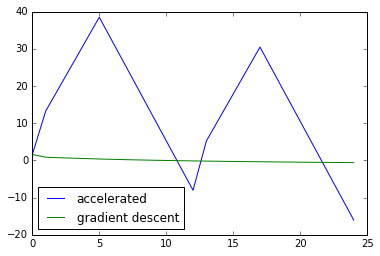

In [21]:
d = 3 
mu = 1.0/100.0
cov_mat = np.zeros((d,d))
mean = np.ones(d)
for i in range(d): 
    cov_mat[i,i] = pow(2.5,-i)
    mean[i] = pow(2.5,-i)

diag, v = np.linalg.eig(cov_mat)

w_star = np.dot(np.linalg.inv(cov_mat),mean)
#opt_risk = risk_ridge(w_start,X,y,lambda_main)

def grad_eff(w): 
    g = np.dot(cov_mat,w)
    g = (g-mean)
    return g,1.0
def gradient_desc_adapt_steps(grad,risk,itrs,w0 = None): 
    if w0 is None: 
        w = np.zeros(d)
    else: 
        w = w0
    effective_iters = 0
    stat = [0,risk(w)]
   # stepsizes = [1000-1,0.9]
   # iter_per_step = [1,4]
    stepsizes = np.ones(2*d)
    iter_per_step = np.ones(2*d)
    for i in range(d): 
        stepsizes[i] = pow(2,d-1-i)
        iter_per_step[i] = d*i + 1
    ind_stepsize = 0
    itr_stepsize = 0
    while effective_iters < itrs: 
        g, c = grad(w)
        if itr_stepsize>=iter_per_step[ind_stepsize] : 
            ind_stepsize = (ind_stepsize+1) % len(stepsizes)
            itr_stepsize = 0
        step_size = stepsizes[ind_stepsize]
        itr_stepsize = itr_stepsize + 1
        w = w-step_size*g
        step_size = step_size
        effective_iters = effective_iters+c
        risk_value = risk(w)
        n_stat = [effective_iters,risk_value]
        stat = np.c_[stat,n_stat]
        #print("loss[{}]={}".format(effective_iters,risk_value))
    return stat,w
def gradient_desc_simple(grad,risk,itrs,w0 = None): 
    if w0 is None: 
        w = np.zeros(d)
    else: 
        w = w0
    effective_iters = 0
    stat = [0,risk(w)]
   # stepsizes = [1000-1,0.9]
   # iter_per_step = [1,4]
    stepsizes = [0.9]
    iter_per_step = [10]
    ind_stepsize = 0
    itr_stepsize = 0
    while effective_iters < itrs: 
        g, c = grad(w)
        if itr_stepsize>=iter_per_step[ind_stepsize] : 
            ind_stepsize = (ind_stepsize+1) % len(stepsizes)
            itr_stepsize = 0
        step_size = stepsizes[ind_stepsize]
        itr_stepsize = itr_stepsize + 1
        w = w-step_size*g
        step_size = step_size
        effective_iters = effective_iters+c
        risk_value = risk(w)
        n_stat = [effective_iters,risk_value]
        stat = np.c_[stat,n_stat]
        #print("loss[{}]={}".format(effective_iters,risk_value))
    return stat,w

def general_risk_eval(w): 
    delta = w-w_star
    return pow(np.linalg.norm(delta),2)
[stat,w] = gradient_desc_adapt_steps(grad_eff,general_risk_eval,24)
[stat2,w2] = gradient_desc_simple(grad_eff,general_risk_eval,24)
plt.plot((stat[0,:]),np.log2(stat[1,:]),label= 'accelerated')
plt.plot((stat2[0,:]),np.log2(stat2[1,:]),label= 'gradient descent')
plt.legend(loc='bottom left')
plt.savefig('fantastic_result.eps')
# for j in range(2):
#     ind = (1-j)
#     def risk_eval(w):
#         delta = np.dot(v.transpose(),w )
#         hat = np.dot(v.transpose(),mean)
#         delta = delta[ind]-hat[ind]/(diag[ind])
#         return abs(delta)
#     [stat,w] = gradient_desc_adapt_steps(grad_eff,risk_eval,6)
#     label_i = 'lambda:%f' % diag[ind]
#     plt.plot((stat[0,:]),np.log2(stat[1,:]),label= label_i)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [10]:
w2

array([ 99.999999 ,   6.9772368])

In [ ]:
def obj_nest(w,mu,reg): 
    d = len(w)
    error = 0.5*w[0]*w[0]- w[0]
    for i in range(d-1): 
        delta = w[i]-w[i+1]
        error = error + 0.5*(delta*delta)
    error = .25*(1-mu)*error
    error = error + .5*reg*pow(np.linalg.norm(w),2)
    return error
def get_star(d,mu): 
    w = np.zeros(d)
    q = (math.sqrt(1.0/mu)-1)/(math.sqrt(1.0/mu)+1)
    for i in range(d): 
        w[i] = pow(q,i+1)
    return w
def grad_nest(w,mu,reg): 
    d = len(w)
    A = np.diag(2*np.ones(d))
    for i in range(d-1): 
        A[i,i+1] = -1
        A[i+1,i] = -1
    e1 = np.zeros(d)
    e1[0] = 1
    return np.dot(0.25*(1-mu)*A + reg* np.eye(d),w) - 0.25*(1-mu)*e1

d = 100; 
mu = 0.001
w_star = get_star(d,mu)
opt_obj = obj_nest(w_star,mu,mu)
inital_vec = 10*np.random.randn(d)
inital_vec = np.zeros(d)
w = inital_vec
w_acc = inital_vec
T = 1000; 
mu2 = 10*mu 
errors = np.zeros(T)
errors_acc = np.zeros(T)
step_size = 0.1
for t in range(T): 
   #print(grad_nest(w,mu))
   w = w - step_size*grad_nest(w,mu,mu)
   w_acc = w_acc - step_size*grad_nest(w_acc,mu,mu2) 
   delta = w - w_star
   delta2 = w_acc - w_star
   errors[t] = obj_nest(w,mu,mu)-opt_obj
   errors_acc[t] = obj_nest(w_acc,mu,mu)-opt_obj
#    errors[t] = pow(np.linalg.norm(delta),2)
#    errors_acc[t] = pow(np.linalg.norm(delta2),2)
plt.plot(range(T),np.log2(errors),label = 'nest')
plt.plot(range(T),np.log2(errors_acc), label = 'acc_nest')
plt.legend()

In [ ]:
opt_obj

In [ ]:
print(obj_nest(w_acc,mu2)-obj_nest(get_star(d,mu,mu),mu))

In [ ]:
get_star(d,0.0000001)

In [ ]:
opt_obj

In [ ]:
A[d-10:d,d-10:d]

In [ ]:
w

In [4]:
int(1.0)

1

In [25]:
import sys
sys.long_info


sys.long_info(bits_per_digit=30, sizeof_digit=4)

In [28]:
a = 1

In [29]:
a = 1 + 1000**10

In [30]:
a

1000000000000000000000000000001L